-  Date: 11/21
-  Last Updated: 12/04
-  Notebook Owner: Reza Naiman
    
    
    
# Key findings

## Model Performance
- The combined weather and flight data model performed the best overall, with accuracies of 0.65 (training), 0.57 (validation), and 0.56 (testing). This indicates that combining weather and flight data provides a more comprehensive view for predictions.


- The weather-only model achieved similar validation and testing accuracies (0.57 and 0.56, respectively) but slightly lower training accuracy (0.62), suggesting weather data alone captures significant but not all predictive signals.

- The flight-only model showed the weakest performance, particularly on the validation set (accuracy: 0.38), highlighting that flight data alone may not be sufficient for reliable predictions.

## Feature Importance
- Weather Features:
   - The most critical weather features were Apparent Temperature Fahrenheit and Hourly Precipitation Inches, appearing in both the combined and weather-only models.This emphasizes the impact of weather conditions on the outcomes.
- Flight Features:
   - Day of Month and Scheduled Departure Time were the key features in the flight-only model, suggesting that scheduling and timing are relevant but not as impactful as weather-related factors.
   
## Suggestions
- Combining weather and flight data is essential for better predictive performance, as no single dataset is sufficient on its own.Weather conditions, particularly temperature and precipitation, consistently stand out as critical predictive factors based on the Decision Tree Models.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
import shap


### Data cleaning and preparation for Illinois and Georgia datasets

In [ ]:
# Load and inspect the data
df = pd.read_csv("/content/Illinois_10_years_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2969937 entries, 0 to 2969936
Data columns (total 31 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Year                              int64  
 1   Quarter                           int64  
 2   Month                             int64  
 3   Day_of_Month                      float64
 4   Day_of_Week                       float64
 5   Operating_Carrier_Code            object 
 6   Tail_Number                       object 
 7   Origin_Airport_ID                 float64
 8   Origin_Airport_Code               object 
 9   Origin_State_Name                 object 
 10  Destination_Airport_Code          object 
 11  Destination_State_Name            object 
 12  Scheduled_Departure_Time          float64
 13  Departure_Delay_Minutes           float64
 14  Taxi_Out_Time_Minutes             float64
 15  Flight_Distance_Miles             float64
 16  Departure_Datetime                ob

In [ ]:
df_g = pd.read_csv("/content/Georgia_10_years_data.csv")
df_g.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107731 entries, 0 to 3107730
Data columns (total 31 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Year                              int64  
 1   Quarter                           int64  
 2   Month                             int64  
 3   Day_of_Month                      float64
 4   Day_of_Week                       float64
 5   Operating_Carrier_Code            object 
 6   Tail_Number                       object 
 7   Origin_Airport_ID                 float64
 8   Origin_Airport_Code               object 
 9   Origin_State_Name                 object 
 10  Destination_Airport_Code          object 
 11  Destination_State_Name            object 
 12  Scheduled_Departure_Time          float64
 13  Departure_Delay_Minutes           float64
 14  Taxi_Out_Time_Minutes             float64
 15  Flight_Distance_Miles             float64
 16  Departure_Datetime                ob

In [ ]:
# Drop unnecessary columns
df = df.drop(['Origin_State_Name', 'Departure_Datetime', 'Departure_Delay_Minutes','Taxi_Out_Time_Minutes'], axis=1)
df_g = df_g.drop(['Origin_State_Name', 'Departure_Datetime', 'Departure_Delay_Minutes','Taxi_Out_Time_Minutes'], axis=1)
df.dropna(inplace=True)
df_g.dropna(inplace=True)

In [ ]:
# Convert integer features to int32
int_columns = [
    'Year',
    'Quarter',
    'Month',
    'Day_of_Month',
    'Day_of_Week',
    'Scheduled_Departure_Time',
    'Scheduled_Departure_Time_Minutes',
    'Target'
]

for col in int_columns:
    df[col] = df[col].astype(np.int32)
    df_g[col] = df_g[col].astype(np.int32)

In [ ]:
# Convert continuous numeric features to float32
float_columns = [

    'Flight_Distance_Miles',
    'Air_Temperature_Fahrenheit',
    'Dew_Point_Temperature_Fahrenheit',
    'Relative_Humidity_Percent',
    'Wind_Direction_Degrees',
    'Wind_Speed_Knots',
    'Hourly_Precipitation_Inches',
    'Pressure_Altimeter_Inches',
    'Sea_Level_Pressure_Millibar',
    'Visibility_Miles',
    'Sky_Level_1_Altitude_Feet',
    'Apparent_Temperature_Fahrenheit',
]

for col in float_columns:
    df[col] = df[col].astype(np.float32)
    df_g[col] = df_g[col].astype(np.float32)

In [ ]:
# Convert categorical features to 'category' dtype
categorical_columns = [
    'Operating_Carrier_Code',
    'Tail_Number',
    'Origin_Airport_ID',
    'Origin_Airport_Code',
    'Destination_Airport_Code',
    'Destination_State_Name',
    'Sky_Cover_Level_1'
]

for col in categorical_columns:
    df[col] = df[col].astype('category')
    df_g[col] = df_g[col].astype('category')

In [ ]:
categorical_cols = [
    'Operating_Carrier_Code',
    'Tail_Number',
    'Origin_Airport_ID',
    'Origin_Airport_Code',
    'Destination_Airport_Code',
    'Destination_State_Name',
    'Sky_Cover_Level_1'
]

# Perform one-hot encoding and save back to df
df = pd.get_dummies(df, columns=categorical_cols)
df_g = pd.get_dummies(df_g, columns=categorical_cols)

In [ ]:
df.info()
df_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2969937 entries, 0 to 2969936
Data columns (total 27 columns):
 #   Column                            Dtype   
---  ------                            -----   
 0   Year                              int32   
 1   Quarter                           int32   
 2   Month                             int32   
 3   Day_of_Month                      int32   
 4   Day_of_Week                       int32   
 5   Operating_Carrier_Code            category
 6   Tail_Number                       category
 7   Origin_Airport_ID                 category
 8   Origin_Airport_Code               category
 9   Destination_Airport_Code          category
 10  Destination_State_Name            category
 11  Scheduled_Departure_Time          int32   
 12  Flight_Distance_Miles             float32 
 13  Scheduled_Departure_Time_Minutes  int32   
 14  Air_Temperature_Fahrenheit        float32 
 15  Dew_Point_Temperature_Fahrenheit  float32 
 16  Relative_Humidity_

In [ ]:
df.shape
df_g.shape

(3107731, 27)

In [ ]:
df.head()

,Year,Quarter,Month,Day_of_Month,Day_of_Week,Operating_Carrier_Code,Tail_Number,Origin_Airport_ID,Origin_Airport_Code,Destination_Airport_Code,...,Wind_Direction_Degrees,Wind_Speed_Knots,Hourly_Precipitation_Inches,Pressure_Altimeter_Inches,Sea_Level_Pressure_Millibar,Visibility_Miles,Sky_Cover_Level_1,Sky_Level_1_Altitude_Feet,Apparent_Temperature_Fahrenheit,Target
0,2014,2,4,1,2,AA,N359AA,13930.0,ORD,DFW,...,260.0,15.0,0.0,30.0,1014.200012,10.0,SCT,22000.0,40.279999,0
1,2014,2,4,1,2,AA,N3ADAA,13930.0,ORD,LAS,...,260.0,24.0,0.0,30.0,1008.900024,10.0,SCT,2800.0,20.440001,0
2,2014,2,4,1,2,AA,N3AKAA,13930.0,ORD,MIA,...,220.0,15.0,0.0,30.0,1004.200012,10.0,SCT,4300.0,55.040001,0
3,2014,2,4,1,2,AA,N3AKAA,13930.0,ORD,SEA,...,250.0,20.0,0.0,30.0,1011.500000,10.0,OVC,2600.0,21.740000,0
4,2014,2,4,1,2,AA,N3ANAA,13930.0,ORD,LAX,...,220.0,15.0,0.0,30.0,1004.200012,10.0,CLR,4700.0,55.259998,0


In [ ]:
df_g.head()

,Year,Quarter,Month,Day_of_Month,Day_of_Week,Operating_Carrier_Code,Tail_Number,Origin_Airport_ID,Origin_Airport_Code,Destination_Airport_Code,...,Wind_Direction_Degrees,Wind_Speed_Knots,Hourly_Precipitation_Inches,Pressure_Altimeter_Inches,Sea_Level_Pressure_Millibar,Visibility_Miles,Sky_Cover_Level_1,Sky_Level_1_Altitude_Feet,Apparent_Temperature_Fahrenheit,Target
0,2014,2,4,1,2,AA,N012AA,10397.0,ATL,DFW,...,210.0,10.0,0.0,30.0,1018.200012,10.0,FEW,12000.0,78.419998,0
1,2014,2,4,1,2,AA,N013AA,10397.0,ATL,DFW,...,70.0,1.0,0.0,30.0,1018.700012,10.0,BKN,25000.0,57.020000,0
2,2014,2,4,1,2,AA,N015AA,10397.0,ATL,DFW,...,310.0,6.0,0.0,30.0,1021.299988,10.0,SCT,12000.0,65.300003,0
3,2014,2,4,1,2,AA,N3AWAA,10397.0,ATL,MIA,...,300.0,5.0,0.0,30.0,1021.200012,10.0,SCT,12000.0,66.559998,0
4,2014,2,4,1,2,AA,N3BUAA,10397.0,ATL,MIA,...,290.0,3.0,0.0,30.0,1018.599976,10.0,BKN,25000.0,56.480000,0


Now we subset the data to get data for four seasons. We will use January for winter, April for spring, July for summer and October for fall.

In [ ]:
winter_il = df[df['Month'] == 1]
spring_il = df[df['Month'] == 4]
summer_il = df[df['Month'] == 7]
fall_il = df[df['Month'] == 10]

winter_ga = df_g[df_g['Month'] == 1]
spring_ga = df_g[df_g['Month'] == 4]
summer_ga = df_g[df_g['Month'] == 7]
fall_ga = df_g[df_g['Month'] == 10]

In [ ]:
# IL sperating flight and weather data into its seprate dataframes
#winter
winter_il_flight = winter_il.iloc[:, :14]
winter_il_flight['Target'] = winter_il['Target']
winter_il_weather = winter_il.iloc[:, 14:]
winter_il_weather['Target'] = winter_il['Target']
winter_il_weather['Year'] = winter_il['Year']


#spring
spring_il_flight = spring_il.iloc[:, :14]
spring_il_flight['Target'] = spring_il['Target']
spring_il_weather = spring_il.iloc[:, 14:]
spring_il_weather['Target'] = spring_il['Target']
spring_il_weather['Year'] = spring_il['Year']

#summer
summer_il_flight = summer_il.iloc[:, :14]
summer_il_flight['Target'] = summer_il['Target']
summer_il_weather = summer_il.iloc[:, 14:]
summer_il_weather['Target'] = summer_il['Target']
summer_il_weather['Year'] = summer_il['Year']


#fall
fall_il_flight = fall_il.iloc[:, :14]
fall_il_flight['Target'] = fall_il['Target']
fall_il_weather = fall_il.iloc[:, 14:]
fall_il_weather['Target'] = fall_il['Target']
fall_il_weather['Year'] = fall_il['Year']


# GA
#winter
winter_ga_flight = winter_ga.iloc[:, :14]
winter_ga_flight['Target'] = winter_ga['Target']
winter_ga_weather = winter_ga.iloc[:, 14:]
winter_ga_weather['Target'] = winter_ga['Target']
winter_ga_weather['Year'] = winter_ga['Year']


#spring
spring_ga_flight = spring_ga.iloc[:, :14]
spring_ga_flight['Target'] = spring_ga['Target']
spring_ga_weather = spring_ga.iloc[:, 14:]
spring_ga_weather['Target'] = spring_ga['Target']
spring_ga_weather['Year'] = spring_ga['Year']

#summer
summer_ga_flight = summer_ga.iloc[:, :14]
summer_ga_flight['Target'] = summer_ga['Target']
summer_ga_weather = summer_ga.iloc[:, 14:]
summer_ga_weather['Target'] = summer_ga['Target']
summer_ga_weather['Year'] = summer_ga['Year']

#fall
fall_ga_flight = fall_ga.iloc[:, :14]
fall_ga_flight['Target'] = fall_ga['Target']
fall_ga_weather = fall_ga.iloc[:, 14:]
fall_ga_weather['Target'] = fall_ga['Target']
fall_ga_weather['Year'] = fall_ga['Year']

In [ ]:
# Define years for train, validation, and test sets
train_years = [2014, 2015, 2016, 2017, 2018, 2019]
val_years = [2020, 2021, 2022]
test_years = [2023, 2024]

## Winter Model for Illinois Data

In [ ]:
# prompt: for winter_il, winter_il_flight and winter_il_weather split the data into training, testing, and validation given those years

# Split data into train, validation, and test sets for winter_il, winter_il_flight, and winter_il_weather
# Assuming 'Year' column exists in your dataframes

winter_il_train = winter_il[winter_il['Year'].isin(train_years)]
winter_il_val = winter_il[winter_il['Year'].isin(val_years)]
winter_il_test = winter_il[winter_il['Year'].isin(test_years)]

winter_il_flight_train = winter_il_flight[winter_il_flight['Year'].isin(train_years)]
winter_il_flight_val = winter_il_flight[winter_il_flight['Year'].isin(val_years)]
winter_il_flight_test = winter_il_flight[winter_il_flight['Year'].isin(test_years)]

winter_il_weather_train = winter_il_weather[winter_il_weather['Year'].isin(train_years)]
winter_il_weather_val = winter_il_weather[winter_il_weather['Year'].isin(val_years)]
winter_il_weather_test = winter_il_weather[winter_il_weather['Year'].isin(test_years)]

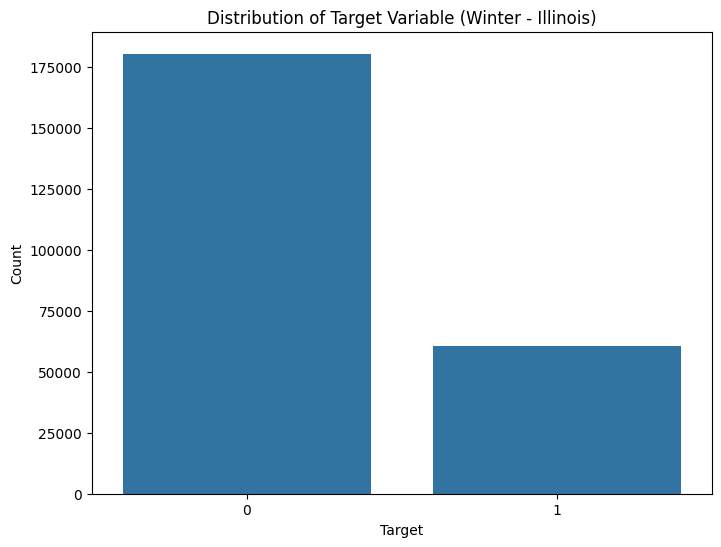

In [ ]:
# prompt: plot the distribution of the Target variable

# Plot the distribution of the 'Target' variable for the winter_il dataset
plt.figure(figsize=(8, 6))
sns.countplot(x='Target', data=winter_il)
plt.title('Distribution of Target Variable (Winter - Illinois)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [ ]:
# prompt: apply smote to il_train, il_flight_train, il_weather_train

# Apply SMOTE to the training datasets
# Apply SMOTE to the training datasets
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Separate features (X) and target (y) for each dataset
X_il_train = winter_il_train.drop('Target', axis=1)
y_il_train = winter_il_train['Target']

X_il_flight_train = winter_il_flight_train.drop('Target', axis=1)
y_il_flight_train = winter_il_flight_train['Target']

X_il_weather_train = winter_il_weather_train.drop('Target', axis=1)
y_il_weather_train = winter_il_weather_train['Target']

# Convert categorical features to numerical using one-hot encoding
# Get categorical columns for each DataFrame separately
categorical_cols_il = X_il_train.select_dtypes(include=['category', 'object']).columns
categorical_cols_flight = X_il_flight_train.select_dtypes(include=['category', 'object']).columns
categorical_cols_weather = X_il_weather_train.select_dtypes(include=['category', 'object']).columns


X_il_train = pd.get_dummies(X_il_train, columns=categorical_cols_il, drop_first=True)
X_il_flight_train = pd.get_dummies(X_il_flight_train, columns=categorical_cols_flight, drop_first=True) # Use categorical_cols_flight here
X_il_weather_train = pd.get_dummies(X_il_weather_train, columns=categorical_cols_weather, drop_first=True) # Use categorical_cols_weather here


# Apply SMOTE
X_il_train_smote, y_il_train_smote = smote.fit_resample(X_il_train, y_il_train)
X_il_flight_train_smote, y_il_flight_train_smote = smote.fit_resample(X_il_flight_train, y_il_flight_train)
X_il_weather_train_smote, y_il_weather_train_smote = smote.fit_resample(X_il_weather_train, y_il_weather_train)

# Print class distribution after SMOTE
print("Class distribution after SMOTE (Combined):", np.unique(y_il_train_smote, return_counts=True))
print("Class distribution after SMOTE (Flight):", np.unique(y_il_flight_train_smote, return_counts=True))
print("Class distribution after SMOTE (Weather):", np.unique(y_il_weather_train_smote, return_counts=True))

NameError: name 'winter_il_train' is not defined

## This model is for Flights and Weather Data combined

In [ ]:
# Separate features and target
X_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']
X_val = val_df.drop('Target', axis=1)
y_val = val_df['Target']
X_test = test_df.drop('Target', axis=1)
y_test = test_df['Target']

In [ ]:
X_train.head()

In [ ]:
X_train.info()

In [ ]:
# Ensure consistent encoding across all sets using pd.Categorical
for col in X_train.select_dtypes(include=['category']).columns:
    X_train[col] = pd.Categorical(X_train[col])
    X_val[col] = pd.Categorical(X_val[col], categories=X_train[col].cat.categories)
    X_test[col] = pd.Categorical(X_test[col], categories=X_train[col].cat.categories)

# Convert categorical columns to integer codes
X_train = X_train.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_val = X_val.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_test = X_test.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

In [ ]:
counts_1 = pd.Series(train_df["Target"]).value_counts()
class_counts_df_1 = counts_1.reset_index()
class_counts_df_1.columns = ['Class', 'Count']
sns.barplot(x='Class', y='Count', data=class_counts_df_1)

Based on this bar plot we can see the unbalanced distribution between the two different classes. Therefore, we need to apply SMOTE for class balancing.

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
counts_2 = pd.Series(y_train_smote).value_counts()
class_counts_df_2 = counts_2.reset_index()
class_counts_df_2.columns = ['Class', 'Count']
sns.barplot(x='Class', y='Count', data=class_counts_df_2)

The classes are balanced, we are ready to train the decision tree!

In [ ]:
jan_clf_1 = DecisionTreeClassifier(
    max_depth=5,
    max_leaf_nodes=6,
    min_impurity_decrease=0.01,
    random_state=42
)
jan_clf_1.fit(X_train_smote, y_train_smote)

In [ ]:
y_train_pred = jan_clf_1.predict(X_train_smote)
accuracy_training = round(accuracy_score(y_train_smote, y_train_pred), 2)
print("The accuracy for the training set is :" , accuracy_training)


In [ ]:
cm_training = confusion_matrix(y_train_smote, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_training, annot=True, fmt='d', cmap='Blues', xticklabels=jan_clf_1.classes_, yticklabels=jan_clf_1.classes_)
plt.title('Confusion Matrix (Training set Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
y_val_pred = jan_clf_1.predict(X_val)
accuracy_val = round(accuracy_score(y_val, y_val_pred), 2)
print("The accuracy for the training set is :" , accuracy_val)

In [ ]:
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=jan_clf_1.classes_, yticklabels=jan_clf_1.classes_)
plt.title('Confusion Matrix (Validation set Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
y_test_pred = jan_clf_1.predict(X_test)
accuracy_test = round(accuracy_score(y_test, y_test_pred), 2)
print("The accuracy for the test set is :" , accuracy_test)

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=jan_clf_1.classes_, yticklabels=jan_clf_1.classes_)
plt.title('Confusion Matrix (test set Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
#training
y_train_pred = jan_clf_1.predict(X_train_smote)
print("Classification Report (Training Set):")
print(classification_report(y_train_smote, y_train_pred))




In [ ]:
# Validation
y_val_pred = jan_clf_1.predict(X_val)
print("Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))



In [ ]:
# Test
y_test_pred = jan_clf_1.predict(X_test)
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

In [ ]:

feature_importance = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': jan_clf_1.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, color='blue')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Summary of combined weather and flight data model
- Accuracy for training 0.65
- Accuracy for validation 0.57
- Accuracy for testing 0.56
### Most Important features
- Hourly Precipitation Inches
- Apparent Temperature Fahrenheit

# Model for flights data only

In [ ]:
flights_columns = [
    "Quarter", "Month", "Day_of_Month", "Day_of_Week", "Operating_Carrier_Code", "Tail_Number",
    "Origin_Airport_ID", "Origin_Airport_Code", "Destination_Airport_Code",
    "Destination_State_Name", "Scheduled_Departure_Time",
    "Flight_Distance_Miles", "Scheduled_Departure_Time_Minutes"
]


In [ ]:
X_train_flight = train_df[flights_columns]
y_train_flight = train_df['Target']
X_val_flight = val_df[flights_columns]
y_val_flight = val_df['Target']
X_test_flight = test_df[flights_columns]
y_test_flight = test_df['Target']

In [ ]:
X_train_flight.info()

In [ ]:
X_train_flight.head()

In [ ]:

for col in X_train_flight.select_dtypes(include=['category']).columns:
    X_train_flight[col] = pd.Categorical(X_train_flight[col])
    X_val_flight[col] = pd.Categorical(X_val_flight[col], categories=X_train_flight[col].cat.categories)
    X_test_flight[col] = pd.Categorical(X_test_flight[col], categories=X_train_flight[col].cat.categories)


X_train_flight = X_train_flight.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_val_flight = X_val_flight.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_test_flight = X_test_flight.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)


In [ ]:

smote = SMOTE(random_state=42)
X_train_flight_smote, y_train_flight_smote = smote.fit_resample(X_train_flight, y_train_flight)

In [ ]:

jan_clf_flight = DecisionTreeClassifier(
    max_depth=5,
    max_leaf_nodes=6,
    min_impurity_decrease=0.01,
    random_state=42
)


jan_clf_flight.fit(X_train_flight_smote, y_train_flight_smote)



In [ ]:

y_train_flight_pred = jan_clf_flight.predict(X_train_flight_smote)


accuracy_training_flight = round(accuracy_score(y_train_flight_smote, y_train_flight_pred), 2)

print("The accuracy for the training set is:", accuracy_training_flight)


In [ ]:
cm_training_flight = confusion_matrix(y_train_flight_smote, y_train_flight_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_training_flight, annot=True, fmt='d', cmap='Blues',
            xticklabels=jan_clf_flight.classes_,
            yticklabels=jan_clf_flight.classes_)
plt.title('Confusion Matrix (Training Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:

y_val_flight_pred = jan_clf_flight.predict(X_val_flight)


accuracy_validation_flight = round(accuracy_score(y_val_flight, y_val_flight_pred), 2)


print("The accuracy for the validation set is:", accuracy_validation_flight)


In [ ]:
cm_validation_flight = confusion_matrix(y_val_flight, y_val_flight_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_validation_flight, annot=True, fmt='d', cmap='Blues',
            xticklabels=jan_clf_flight.classes_,
            yticklabels=jan_clf_flight.classes_)
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:

y_test_flight_pred = jan_clf_flight.predict(X_test_flight)

accuracy_test_flight = round(accuracy_score(y_test_flight, y_test_flight_pred), 2)


print("The accuracy for the test set is:", accuracy_test_flight)


In [ ]:

cm_test_flight = confusion_matrix(y_test_flight, y_test_flight_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_flight, annot=True, fmt='d', cmap='Blues',
            xticklabels=jan_clf_flight.classes_,
            yticklabels=jan_clf_flight.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
y_train_flight_pred = jan_clf_flight.predict(X_train_flight_smote)
print("Classification Report (Training Set - Flight Data):")
print(classification_report(y_train_flight_smote, y_train_flight_pred))

In [ ]:
y_val_flight_pred = jan_clf_flight.predict(X_val_flight)
print("\nClassification Report (Validation Set - Flight Data):")
print(classification_report(y_val_flight, y_val_flight_pred))

In [ ]:
y_test_flight_pred = jan_clf_flight.predict(X_test_flight)
print("\nClassification Report (Test Set - Flight Data):")
print(classification_report(y_test_flight, y_test_flight_pred))

In [ ]:
feature_importance_flight = pd.DataFrame({
    'Feature': X_train_flight_smote.columns,
    'Importance': jan_clf_flight.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_flight, color='blue')
plt.title('Feature Importance (Flight Data)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Summary of only flight data model
- Training accuracy 0.6
- Validation accuracy 0.38
- Testing accuracy 0.51

## Most important features
- Day of Month
- Scheduled Departure Time

## Model using only weather data

In [ ]:
weather_columns = [
    "Air_Temperature_Fahrenheit", "Dew_Point_Temperature_Fahrenheit",
    "Relative_Humidity_Percent", "Wind_Direction_Degrees", "Wind_Speed_Knots",
    "Hourly_Precipitation_Inches", "Pressure_Altimeter_Inches",
    "Sea_Level_Pressure_Millibar", "Visibility_Miles", "Sky_Cover_Level_1",
    "Sky_Level_1_Altitude_Feet", "Apparent_Temperature_Fahrenheit"
]


In [ ]:
X_train_weather = train_df[weather_columns]
y_train_weather = train_df['Target']
X_val_weather = val_df[weather_columns]
y_val_weather = val_df['Target']
X_test_weather = test_df[weather_columns]
y_test_weather = test_df['Target']

In [ ]:
X_train_weather.info()

In [ ]:
X_train_weather.head()

In [ ]:

for col in X_train_weather.select_dtypes(include=['category']).columns:
    X_train_weather[col] = pd.Categorical(X_train_weather[col])
    X_val_weather[col] = pd.Categorical(X_val_weather[col], categories=X_train_weather[col].cat.categories)
    X_test_weather[col] = pd.Categorical(X_test_weather[col], categories=X_train_weather[col].cat.categories)

X_train_weather = X_train_weather.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_val_weather = X_val_weather.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
X_test_weather = X_test_weather.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)


In [ ]:
smote = SMOTE(random_state=42)

X_train_weather_smote, y_train_weather_smote = smote.fit_resample(X_train_weather, y_train_weather)

In [ ]:
jan_clf_weather = DecisionTreeClassifier(
    max_depth=5,
    max_leaf_nodes=6,
    min_impurity_decrease=0.01,
    random_state=42
)


jan_clf_weather.fit(X_train_weather_smote, y_train_weather_smote)


In [ ]:
y_train_weather_pred = jan_clf_weather.predict(X_train_weather_smote)

accuracy_training_weather = round(accuracy_score(y_train_weather_smote, y_train_weather_pred), 2)


print("The accuracy for the weather-specific training set is:", accuracy_training_weather)

In [ ]:
cm_training_weather = confusion_matrix(y_train_weather_smote, y_train_weather_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm_training_weather, annot=True, fmt='d', cmap='Blues',
            xticklabels=jan_clf_weather.classes_,
            yticklabels=jan_clf_weather.classes_)
plt.title('Confusion Matrix (Training Set - Weather Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
y_val_weather_pred = jan_clf_weather.predict(X_val_weather)
accuracy_validation_weather = round(accuracy_score(y_val_weather, y_val_weather_pred), 2)
print("The accuracy for the weather-specific validation set is:", accuracy_validation_weather)

In [ ]:
cm_validation_weather = confusion_matrix(y_val_weather, y_val_weather_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_validation_weather, annot=True, fmt='d', cmap='Blues',
            xticklabels=jan_clf_weather.classes_,
            yticklabels=jan_clf_weather.classes_)
plt.title('Confusion Matrix (Validation Set - Weather Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
y_test_weather_pred = jan_clf_weather.predict(X_test_weather)
accuracy_test_weather = round(accuracy_score(y_test_weather, y_test_weather_pred), 2)
print("The accuracy for the weather-specific test set is:", accuracy_test_weather)

In [ ]:
cm_test_weather = confusion_matrix(y_test_weather, y_test_weather_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_weather, annot=True, fmt='d', cmap='Blues',
            xticklabels=jan_clf_weather.classes_,
            yticklabels=jan_clf_weather.classes_)
plt.title('Confusion Matrix (Test Set - Weather Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
y_train_weather_pred = jan_clf_weather.predict(X_train_weather_smote)
print("Classification Report (Training Set - Weather Data):")
print(classification_report(y_train_weather_smote, y_train_weather_pred))

In [ ]:
y_val_weather_pred = jan_clf_weather.predict(X_val_weather)
print("\nClassification Report (Validation Set - Weather Data):")
print(classification_report(y_val_weather, y_val_weather_pred))

In [ ]:
y_test_weather_pred = jan_clf_weather.predict(X_test_weather)
print("\nClassification Report (Test Set - Weather Data):")
print(classification_report(y_test_weather, y_test_weather_pred))

In [ ]:
feature_importance_weather = pd.DataFrame({
    'Feature': X_train_weather_smote.columns,
    'Importance': jan_clf_weather.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_weather, color='blue')
plt.title('Feature Importance (Weather Data)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Summary of the weather only data model
- Training Accuracy 0.62
- Validation Accuracy 0.57
- Testing Accuracy 0.56

## Most important features
- Apparent Temperature Fahrenheit
- Hourly Precipitation Inches
